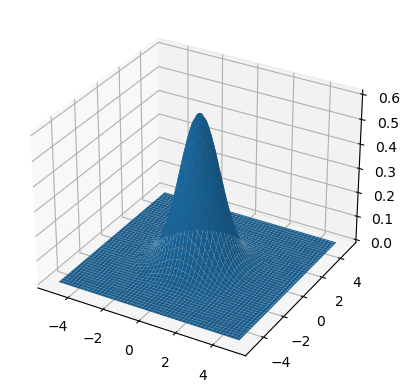

In [5]:
# define a 2d gaussian function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#define a 2d gaussian function that decays exponentially as a function of time
def gaussian_t(x, y, x0, y0, sigma, t):
    decayConstant = 0.5
    return np.exp(-((x-x0)**2 + (y-y0)**2)/(2*sigma**2)) * np.exp(-decayConstant*t)

# define a grid between -5 and 5 (representing km)
x = np.linspace(-5, 5, 100)

# create a meshgrid
X, Y = np.meshgrid(x, x)

# create the 2d gaussian
Z = gaussian_t(X, Y, 0, 0, 1, 1)

# plot the 2d gaussian
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)
plt.show()


In [138]:
initial_uncertainty = 0.2 #200 meters
uncertainty_decay = 0.1
minimum_uncertainty = 0.05 #50 meters
meas_uncertainty = 0.01
n_detectors = 20
n_time_samples = 20

# create a list of n_samples random x and y values within the range -5 to 5
x_test = np.random.uniform(-5, 5, n_detectors)
y_test = np.random.uniform(-5, 5, n_detectors)

# sample the 2d gaussian at these x and y values for each time sample assuming they are sampled as a batch with a time step of 1
z_test = np.array([gaussian_t(x_test, y_test, 0, 0, 1, t) for t in range(n_time_samples)])
z_test = z_test.transpose()

(20, 20)


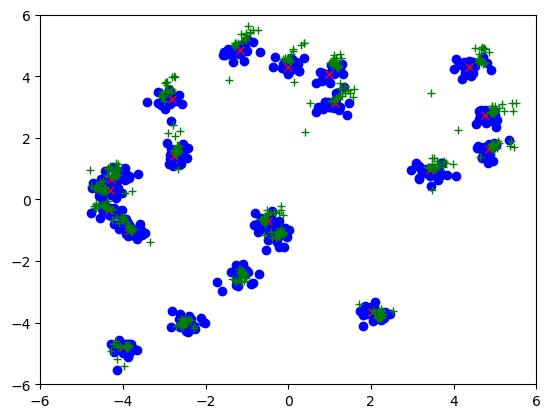

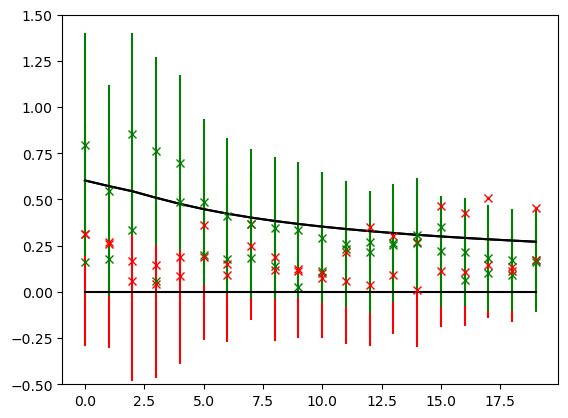

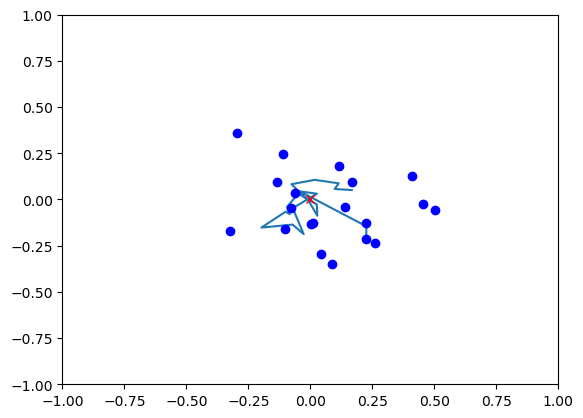

In [139]:
from filterpy.kalman import KalmanFilter
import numpy as np

pos_uncertainty = 0.200 #200 meters
#create position measurements with noise
x_random = x_test.reshape(1, n_detectors) + np.random.normal(0, pos_uncertainty, (n_time_samples, n_detectors))
y_random = y_test.reshape(1, n_detectors) + np.random.normal(0, pos_uncertainty, (n_time_samples, n_detectors))

#initialize the kalman filters
filters = []
for _ in range(n_detectors):
    f = KalmanFilter(dim_x=4, dim_z=2)
    f.x = np.array([x_random[0,0], y_random[0,0], 0, 0])
    f.F = np.array([[1, 0, 1, 0],
                    [0, 1, 0, 1],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])
    f.H = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0]])
    #f.P *= 1000
    # Define the measurement noise covariance
    f.R = np.eye(2) * 0.2 # Measurement noise

    # Define the process noise covariance
    f.Q = np.eye(4) * 1e-6  # Process noise

    filters.append(f)

#initialize the filtered positions
filtered_positions = []
filter_uncertainty = []

#iterate through the time samples
for t in range(n_time_samples):
    #iterate through the detectors
    for i in range(n_detectors):
        #predict the position
        filters[i].predict()
        #update the position with the measurement
        filters[i].update(np.array([x_random[t, i], y_random[t, i]]))
        #append the filtered position to the list
        filtered_positions.append(filters[i].x)
        #append the calculated uncertainty to the list as a tuple
        filter_uncertainty.append( [np.sqrt(filters[i].P[0, 0]), np.sqrt(filters[i].P[1, 1])] )

filtered_positions = np.array(filtered_positions).reshape(n_time_samples, n_detectors, 4)
filter_uncertainty = np.array(filter_uncertainty).reshape(n_time_samples, n_detectors, 2)
x_uncertainty = filter_uncertainty[:, :, 0]
y_uncertainty = filter_uncertainty[:, :, 1]

print(x_uncertainty.shape)

# plot the original and filtered x and y positions
plt.plot(x_random, y_random, 'bo')
#plot the true position as a red x
plt.plot(x_test, y_test, 'rx')
#plot the filtered position as a green +
plt.plot(filtered_positions[:, :, 0], filtered_positions[:, :, 1], 'g+')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
#plot the estimated distance from the true position for all single detectors along with the uncertainty as error bars
for i in range(2):
    distance = np.sqrt((filtered_positions[:, i, 0] - x_test[i])**2 + (filtered_positions[:, i, 1] - y_test[i])**2)
    uncertainty = np.sqrt(x_uncertainty[:,i]**2 + y_uncertainty[:,i]**2)
    plt.errorbar(range(n_time_samples), distance, yerr=uncertainty, fmt='x', color=colors[i])
    plt.plot(range(n_time_samples), uncertainty, 'k')
#plot the measured distance from the true position for all single detectors
for i in range(2):
    distance = np.sqrt((x_random[:, i] - x_test[i])**2 + (y_random[:, i] - y_test[i])**2)
    plt.plot(range(n_time_samples), distance, 'x', color=colors[i])
#plot a horizontal line at 0
plt.plot(range(n_time_samples), np.zeros(n_time_samples), 'k')

plt.ylim(-0.5,1.5)
plt.show()

#plot the x,y predicted position for a detector, offset by the true position so it is centered around 0
plt.plot(filtered_positions[:, 0, 0] - x_test[0], filtered_positions[:, 0, 1] - y_test[0])
plt.plot(x_random[:, 0] - x_test[0], y_random[:, 0] - y_test[0], 'bo')
plt.plot(0, 0, 'rx')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np



#modify the z's by adding a random number from a normal distribution with a mean of 0 and a standard deviation of 0.1
z_train = z_test + np.random.normal(0, meas_uncertainty, (n_detectors, n_time_samples))

print(x_test.shape, y_test.shape, z_test.shape)
print(x_train.shape, y_train.shape, z_train.shape)

# plot the random samples and their values represented by the size of the marker with blue circles for the train data and red crosses for the test data
# plot the nth time sample
n = 0
plt.scatter(x_train[:,n], y_train[:,n], s=z_train[:,n]*100, c='b', alpha=0.5, label='train')
plt.scatter(x_test, y_test, s=z_test[:,n]*100, c='r', marker='x', label='test')
plt.contour(X, Y, gaussian_t(X, Y, 0, 0, 1, n))
plt.title('Time sample ' + str(n))
plt.legend()
plt.show()

n = 9
plt.scatter(x_train[:,n], y_train[:,n], s=z_train[:,n]*100, c='b', alpha=0.5, label='train')
plt.scatter(x_test, y_test, s=z_test[:,n]*100, c='r', marker='x', label='test')
plt.contour(X, Y, gaussian_t(X, Y, 0, 0, 1, n))
plt.title('Time sample ' + str(n))
plt.legend()
plt.show()

#plot the dose rate reading for a single detector over time, choose the detector with the highest reading at the first time sample
d = np.argmax(z_test[:,0])
plt.plot(z_train[d,:], 'b', label='train')
plt.plot(z_test[d,:], 'r', label='test')
plt.title('Detector closest to the source')
plt.ylabel('Dose Rate Reading')
plt.xlabel('Time Sample')
plt.legend()
plt.show()

#plot the euclidean distance between the true and estimated location of the detector closest to the source over time
#and the uncertainty of the location estimate as error bars
distance = np.sqrt((x_train[d,:] - x_test[d])**2 + (y_train[d,:] - y_test[d])**2)
plt.errorbar(range(n_time_samples), distance, yerr=loc_uncertainties, fmt='o')
plt.title('Distance between true and estimated location')
plt.ylabel('Distance (km)')
plt.xlabel('Time Sample')
plt.show()

